In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2425 sha256=f650832df156ac895867ebb670a98678fe3c0286c48d04b303e31ff88b13bafa
  Stored in directory: /root/.cache/pip/wheels/54/1d/51/d65a99106096dd07e3be6f08d5d3c2dd5f26ac98f626e5efc9
Successfully built colabgymrender


In [3]:
from colabgymrender.recorder import Recorder

  np.bool8: (False, True),

  from scipy.ndimage.filters import sobel



In [4]:
# install dependencies
!apt install chromium-browser xvfb

  and should_run_async(code)



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor libfontenc1 libfuse3-3 liblzo2-2 libudev1 libxfont2 libxkbfile1 snapd squashfs-tools
  systemd-hwe-hwdb udev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser libfontenc1 libfuse3-3 liblzo2-2 libxfont2 libxkbfile1 snapd
  squashfs-tools systemd-hwe-hwdb udev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
The following packages will be upgraded:
  libudev1
1 upgraded, 17 newly installed, 0 to remove and 44 not upgraded.
Need to get 36.2 MB of archives.
After this operation, 129 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.3 [595 kB]


In [5]:
env = gym.make('MountainCar-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



-200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [6]:
total_reward

  and should_run_async(code)



-200.0

In [7]:
# # Hyperparameters
# max_epsilon = 1.0
# min_epsilon = 0.01
# max_num_steps = 50000
# epsilon_decay_intervals = 10000
# gamma = 0.99 # discount
# alpha = 5e-4 # learning rate

# memory_size = 50000
# min_replay_size = 1000
# batch_size = 32

# target_update_frequency = 1000 # target network update frequency

# Hyperparameters
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.001
max_num_steps = 400000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 0.00085# learning rate

memory_size = 100000
min_replay_size = 1000
batch_size = 256

target_update_frequency = 1000 # target network update frequency

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Sigmoid(),
            nn.Linear(128, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [9]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [10]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        if len(memory) >= batch_size:
            experiences = random.sample(memory, batch_size)
            states = torch.tensor([ex[0] for ex in experiences], dtype=torch.float32)
            actions = torch.tensor([ex[1] for ex in experiences], dtype=torch.int64).unsqueeze(-1)  # (batch_size,) --> (batch_size, 1)
            rewards = torch.tensor([ex[2] for ex in experiences], dtype=torch.float32).unsqueeze(-1)
            dones = torch.tensor([ex[3] for ex in experiences], dtype=torch.float32).unsqueeze(-1)
            next_states = torch.tensor([ex[4] for ex in experiences], dtype=torch.float32)

            # Compute targets using the formulation sample = r + gamma * max q(s',a')
            target_q_values = target_net(next_states)
            max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
            targets = rewards + gamma * (1 - dones) * max_target_q_values

            # Compute loss
            q_values = q_net(states)
            action_q_values = torch.gather(input=q_values, dim=1, index=actions)
            loss = torch.nn.functional.mse_loss(action_q_values, targets)

            # Gradient descent for q-network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network
            if (step + 1) % target_update_frequency == 0:
                target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [11]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  states = torch.tensor([ex[0] for ex in experiences], dtype=torch.float32)



Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -200.0
Episode: 35 Step: 7000 Average reward: -200.0
Episode: 40 Step: 8000 Average reward: -200.0
Episode: 45 Step: 9000 Average reward: -200.0
Episode: 50 Step: 10000 Average reward: -200.0
Episode: 55 Step: 11000 Average reward: -200.0
Episode: 60 Step: 12000 Average reward: -200.0
Episode: 65 Step: 13000 Average reward: -200.0
Episode: 70 Step: 14000 Average reward: -200.0
Episode: 75 Step: 15000 Average reward: -199.06666666666666
Episode: 80 Step: 16000 Average reward: -198.85
Episode: 85 Step: 17000 Average reward: -198.91764705882352
Episode: 91 Step: 18000 Average reward: -197.3956043956044
Episode: 96 Step: 19000 Average reward: -196.80208333333334
Episode: 102 Step: 20000 Average reward: -195.71
Episode: 107 Ste

  and should_run_async(code)



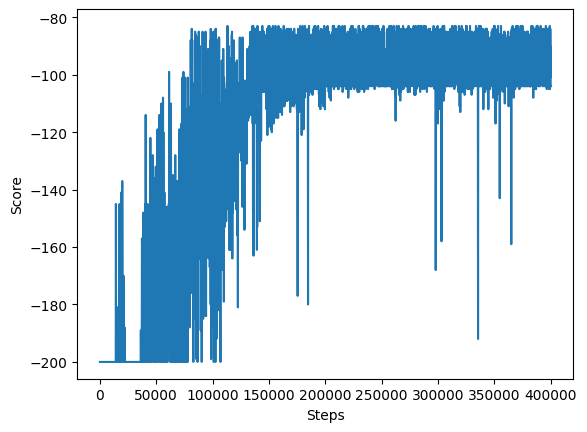

In [12]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [39]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-83.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [38]:
total_rewards = []
num_episodes = 20

for i in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0.0
    q_net.eval()

    with torch.no_grad():
        while not done:
            action = q_net.choose_action(state)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            state = next_state
    print("Trial", i+1, ":", total_reward)
    total_rewards.append(total_reward)

average_reward = sum(total_rewards) / num_episodes
print("Average reward over 20 episodes:", average_reward)

  and should_run_async(code)



Trial 1 : -91.0
Trial 2 : -89.0
Trial 3 : -86.0
Trial 4 : -103.0
Trial 5 : -102.0
Trial 6 : -91.0
Trial 7 : -85.0
Trial 8 : -103.0
Trial 9 : -94.0
Trial 10 : -102.0
Trial 11 : -86.0
Trial 12 : -98.0
Trial 13 : -103.0
Trial 14 : -102.0
Trial 15 : -104.0
Trial 16 : -104.0
Trial 17 : -104.0
Trial 18 : -102.0
Trial 19 : -90.0
Trial 20 : -95.0
Average reward over 20 episodes: -96.7


# Conclusion

In the process, I have changed:

*   Reduce min epsilon to **0.001**
*   Increase learning_rate to **0.00085**
*   Increase the number of loops to **400000**
*   Increase batch size to **256**
*   Increase memory size to **100000**
*   Change activation function: **nn.ReLU()**
*   Change Neural network architecture: add **Linear layer** and input shape = **(128,128)**, add activation function **nn.Sigmoid()**

After many rounds of hyperparameter tuning and adjustments to the network architecture, MountainCar's model utilizing the weights appears to have nearly mastered the task of reaching the destination. The best trial achieved a reward of **-83**, indicating significant progress in learning to navigate the MountainCar environment. However, during random testing of **20** trials, the scores ranged from approximately **-85** to **-104**, with an average reward of **-96.7**
